In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors=ap.COLORS

In [2]:
region="TWP"

In [169]:
models=["SCREAM", "NICAM", "UM"]
cli_profiles = [xr.open_dataset(ap.get_fldmean_file(m, region, "cli")).cli.mean(axis=(0,2,3)) for m in models]
clw_profiles = [xr.open_dataset(ap.get_fldmean_file(m, region, "clw")).clw.mean(axis=(0,2,3)) for m in models]
ta_profiles = [xr.open_dataset(ap.get_fldmean_file(m, region, "ta")).ta.median(axis=(0,2,3)) for m in models]
hus_profiles = [xr.open_dataset(ap.get_fldmean_file(m, region, "hus")).hus.median(axis=(0,2,3)) for m in models]
# qs = xr.open_dataset(ap.get_fldmean()

cli_dict = dict(zip(models, cli_profiles))
clw_dict = dict(zip(models, clw_profiles))
ta_dict = dict(zip(models, ta_profiles))
hus_dict = dict(zip(models, hus_profiles))

In [170]:
um_p = xr.open_dataset(ap.UM_PFULL_MEAN).pfull.mean(axis=(0,2,3))/100
um_p

<xarray.DataArray 'pfull' (model_level_number: 55)>
array([1004.70917 , 1001.7205  ,  997.24896 ,  991.30865 ,  983.919   ,
        975.1041  ,  964.8914  ,  953.3161  ,  940.4174  ,  926.2436  ,
        910.85077 ,  894.303   ,  876.66296 ,  857.99133 ,  838.3543  ,
        817.82153 ,  796.46545 ,  774.3605  ,  751.5831  ,  728.20953 ,
        704.3141  ,  679.97205 ,  655.25946 ,  630.25226 ,  605.02905 ,
        579.6702  ,  554.2894  ,  528.99493 ,  503.85028 ,  478.91467 ,
        454.2409  ,  429.88657 ,  405.91025 ,  382.36673 ,  359.30753 ,
        336.77512 ,  314.80655 ,  293.43817 ,  272.70203 ,  252.627   ,
        233.24161 ,  214.57512 ,  196.65466 ,  179.50494 ,  163.14784 ,
        147.60605 ,  132.90146 ,  119.056755,  106.10759 ,   94.13873 ,
         83.27294 ,   73.56833 ,   64.920586,   57.239292,   50.440098],
      dtype=float32)
Coordinates:
  * model_level_number  (model_level_number) int32 1 2 3 4 5 ... 51 52 53 54 55

In [171]:
hus_zavg = (hus_dict["UM"][1:]+hus_dict["UM"].values[:-1])/2
ta_zavg = (ta_dict["UM"][1:]+ta_dict["UM"].values[:-1])/2
um_dz = ((287*(1 + 0.61*hus_zavg.values)*(ta_zavg.values))/9.8)*np.log((um_p[:-1].values/um_p[1:].values))
um_z = np.cumsum(um_dz)

hus_zavg = (hus_dict["SCREAM"][1:]+hus_dict["SCREAM"].values[:-1])/2
ta_zavg = (ta_dict["SCREAM"][1:]+ta_dict["SCREAM"].values[:-1])/2
sc_p = ta_dict["SCREAM"].lev
print(hus_zavg.shape, ta_zavg.shape, p.shape)
sc_dz = ((287*(1 + 0.61*hus_zavg.values)*(ta_zavg.values))/9.8)*np.log((sc_p[1:].values/sc_p[:-1].values))
sc_z = np.cumsum(sc_dz[::-1])[::-1]
sc_z.shape, ta_zavg.shape

(127,) (127,) (128,)


((127,), (127,))

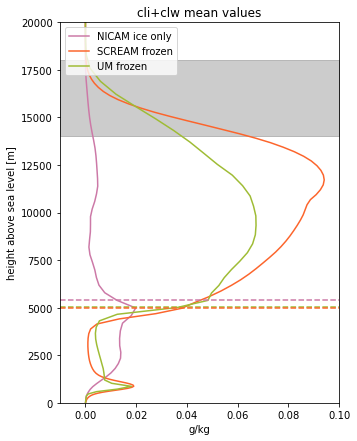

In [188]:
# m="SAM"
# z = "z"
fig, ax = plt.subplots(1,1, figsize=(5,7))
# clw_dict[m].plot(y=z, ax=ax, color=colors[m], linestyle="--")
# cli_dict[m].plot(y=z, ax=ax, color=colors[m], linestyle=":")
# (clw_dict[m]+cli_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m+" cli")

m="NICAM"
z = "lev"
# ((clw_dict[m])*1000).plot(y=z, ax=ax, color=colors[m], linestyle="--")
# ((cli_dict[m])*1000).plot(y=z, ax=ax, color=colors[m], linestyle=":")
((clw_dict[m]+cli_dict[m])*1000).plot(y=z, ax=ax, color=colors[m], label=m+" ice only")

m="SCREAM"
z = "lev"
# ax.plot((clw_dict[m]*1000)[:-1], sc_z, color=colors[m], linestyle="--")
# ax.plot((cli_dict[m]*1000)[:-1], sc_z, color=colors[m], linestyle=":")
ax.plot(((clw_dict[m]+cli_dict[m])*1000)[:-1], sc_z, color=colors[m], label=m+" frozen")

m="UM"
# ax.plot((clw_dict[m]*1000)[:-1], um_z, color=colors[m], linestyle="--")
# ax.plot((cli_dict[m]*1000)[:-1], um_z, color=colors[m], linestyle=":")
ax.plot(((clw_dict[m]+cli_dict[m])*1000)[:-1], um_z, color=colors[m], label=m+" frozen")

ax.legend(loc="upper left")
ax.set_ylim([0,20000])

ax.axhline(um_z[np.argmin(abs(ta_dict["UM"].values-273))], color=colors["UM"], linestyle="--")
ax.axhline(sc_z[np.argmin(abs(ta_dict["SCREAM"].values-273))], color=colors["SCREAM"], linestyle="--")
ax.axhline(clw_dict["NICAM"].lev[np.argmin(abs(ta_dict["NICAM"].values-273))], color=colors["NICAM"], linestyle="--")
# ax.axhline(clw_dict["SAM"].z[np.argmin(abs(ta_dict["SAM"].values-273))], color=colors["SAM"], linestyle="--")

ax.set_xlim([-1e-2,1e-1])
ax.fill_between([-1e-2,1e-1],14000,18000,color="k",alpha=0.2)
ax.set_title("cli+clw mean values")
ax.set_xlabel("g/kg")
plt.savefig("../plots/TWP/TWP_3D_cli+clw_mean_linear.png", dpi=120)
plt.show()

In [99]:
hus_zavg.shape, ta_zavg.shape, ((p_um[:-1].values/p_um[1:].values)*100).shape, p_um.shape, p_um[1:].shape, p_um[:-1].shape

((54,), (54,), (54,), (55,), (54,), (54,))

(55,)

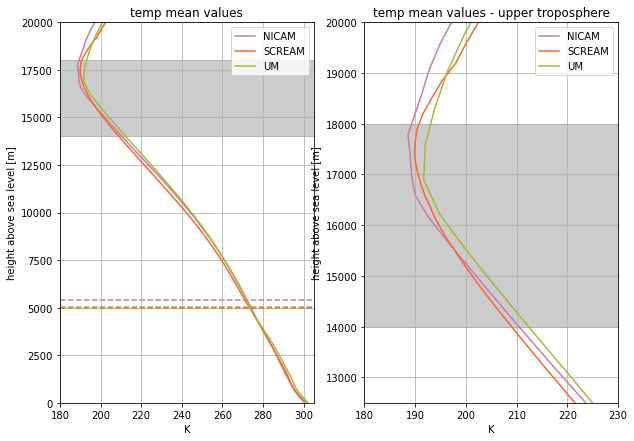

In [154]:
fig, [ax, axt] = plt.subplots(1,2, figsize=(10,7))
# m="SAM"
# z = "z"
# (ta_dict[m]).plot(y=z, ax=ax, color=colors[m], linestyle="--", label=m)
m="NICAM"
z = "lev"
(ta_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(ta_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m)
m="SCREAM"
z = "lev"
ax.plot((ta_dict[m])[:-1], sc_z, color=colors[m], label=m)
axt.plot((ta_dict[m])[:-1], sc_z, color=colors[m], label=m)
m="UM"
ax.plot(ta_dict[m][:-1], um_z, color=colors[m], label=m)
axt.plot(ta_dict[m][:-1], um_z, color=colors[m], label=m)

ax.axhline(p_z[np.argmin(abs(ta_dict["UM"].values-273))], color=colors["UM"], linestyle="--")
ax.axhline(sc_z[np.argmin(abs(ta_dict["SCREAM"].values-273))], color=colors["SCREAM"], linestyle="--")
ax.axhline(clw_dict["NICAM"].lev[np.argmin(abs(ta_dict["NICAM"].values-273))], color=colors["NICAM"], linestyle="--")

ax.fill_between([180,305],14000,18000,color="k",alpha=0.2)
axt.fill_between([180,305],14000,18000,color="k",alpha=0.2)


ax.legend(loc="upper right")
axt.legend(loc="upper right")
ax.set_xlim([180,305])
ax.set_ylim([0,20000])
axt.set_xlim([180,230])
axt.set_ylim([12500,20000])
axt.set_title("temp mean values - upper troposphere")
axt.set_xlabel("K")
ax.set_title("temp mean values")
ax.set_xlabel("K")
ax.grid(True)
axt.grid(True)
plt.savefig("../plots/TWP/TWP_3D_ta_mean.png", dpi=120)
plt.show()

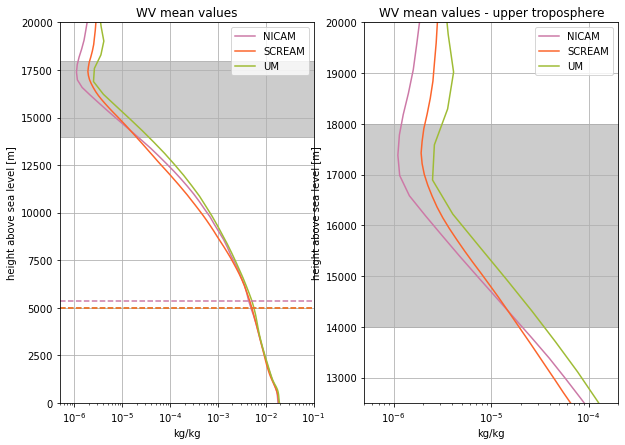

In [153]:
ig, [ax, axt] = plt.subplots(1,2, figsize=(10,7))
# m="SAM"
# z = "z"
# (ta_dict[m]).plot(y=z, ax=ax, color=colors[m], linestyle="--", label=m)
m="NICAM"
z = "lev"
(hus_dict[m]).plot(y=z, ax=ax, color=colors[m], label=m)
(hus_dict[m]).plot(y=z, ax=axt, color=colors[m], label=m)
m="SCREAM"
z = "lev"
ax.plot((hus_dict[m])[:-1], sc_z, color=colors[m], label=m)
axt.plot((hus_dict[m])[:-1], sc_z, color=colors[m], label=m)
m="UM"
ax.plot(hus_dict[m][:-1], um_z, color=colors[m], label=m)
axt.plot(hus_dict[m][:-1], um_z, color=colors[m], label=m)

ax.axhline(p_z[np.argmin(abs(ta_dict["UM"].values-273))], color=colors["UM"], linestyle="--")
ax.axhline(sc_z[np.argmin(abs(ta_dict["SCREAM"].values-273))], color=colors["SCREAM"], linestyle="--")
ax.axhline(clw_dict["NICAM"].lev[np.argmin(abs(ta_dict["NICAM"].values-273))], color=colors["NICAM"], linestyle="--")

ax.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)
axt.fill_between([5e-7,1],14000,18000,color="k",alpha=0.2)

ax.legend(loc="upper right")
axt.legend(loc="upper right")
ax.set_xscale("log")
axt.set_xscale("log")
ax.set_xlim([5e-7,1e-1])
ax.set_ylim([0,20000])
axt.set_xlim([5e-7,2e-4])
axt.set_ylim([12500,20000])
axt.set_title("WV mean values - upper troposphere")
axt.set_xlabel("kg/kg")
ax.set_title("WV mean values")
ax.set_xlabel("kg/kg")
ax.grid(True)
axt.grid(True)
plt.savefig("../plots/TWP/TWP_3D_hus_mean.png", dpi=120)
plt.show()